## An Introduction to Quantile Regression
_Bryan Graham_
_University of California at Berkeley_  
_March 2025_
<br>
<br>
#### Code citation:
<br>
Graham, Bryan S. (2025). "An Introduction to Quantile Regression Python Jupyter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 17 May 2025)
<br>
<br>

In [248]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy.interpolate import griddata
np.warnings.filterwarnings('ignore')

The datafiles for this notebook are available on the course GitHub repository. We will use a 1996 labor force survey from Brazil (PNAD).

In [251]:
# Directory where data files are located
data     =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Data/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/MaCSS/Graphics/'

In [253]:
pnad96 = pd.read_csv(data + 'Brazil_1996PNAD.out', header = 0, sep='\t+', engine='python')

# Find relevant estimation subsample
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)]

#Display the first few rows of the dataframe
sample.describe()

,AgeInDays,YRSSCH,MONTHLY_EARNINGS,Father_NoSchool,Father_Incomplete1stPrimary,Father_Complete1stPrimary,Father_Incomplete2ndPrimary,Father_Complete2ndPrimary,Father_IncompleteSecondary,Father_CompleteSecondary,...,Mother_NoSchool,Mother_Incomplete1stPrimary,Mother_Complete1stPrimary,Mother_Incomplete2ndPrimary,Mother_Complete2ndPrimary,Mother_IncompleteSecondary,Mother_CompleteSecondary,Mother_IncompleteHigher,Mother_CompleteHigher,Mother_DontKnow
count,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,...,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000
mean,37.971992,5.747324,632.051985,0.287575,0.205027,0.138419,0.033425,0.053685,0.052159,0.038802,...,0.341052,0.188288,0.134985,0.040849,0.064370,0.031951,0.044249,0.016392,0.052991,0.084873
std,11.126182,4.231994,1105.739430,0.452636,0.403725,0.345342,0.179746,0.225397,0.222349,0.193126,...,0.474067,0.390945,0.341710,0.197943,0.245413,0.175871,0.205650,0.126978,0.224018,0.278695
min,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.943190,3.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.750170,5.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.895960,8.000000,600.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.996570,15.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Definition of a quantile

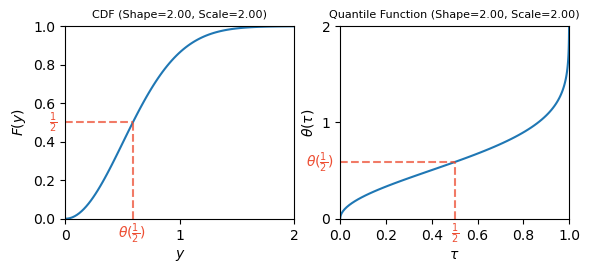

In [255]:
#        Y ~ Weibull(a,b)
#     E[Y] = (b**(-1/a))*Gamma(1+1/a)
# Q_Y(1/2) = (b^(-1/a))*ln(2)**(1/a)

a = 2                                # Weibull shape parameter
b = 2                                # Weibull **rate** parameter (first alternative "econometrics" formulation) 
med_Y = (b**(-1/a))*np.log(2)**(1/a) # Median of Weibull(a,b) rv

# Generate y-values for the CDF
y = np.linspace(0, 2, 100)

# Calculate the F(y)/CDF values
F_y = sp.stats.weibull_min.cdf(y, a, scale=b**(-1/a))

# Plot CDF and associated quantile function
fig_quantile_def, sbp = plt.subplots(1,2, figsize=(6.5, 2.5))

ax0 = sbp[0] # Handle for left subplot
ax1 = sbp[1] # Handle for right subplot

# CDF
ax0.set_xlabel(r'$y$')
ax0.set_xticks([0, 1, 2])
ax0.set_ylabel(r'$F(y)}$')
ax0.set_yticks([0, 0.20, 0.40, 0.60, 0.80, 1])
ax0.plot(y, F_y)
ax0.set_title('CDF (Shape={:.2f}, Scale={:.2f})'.format(a, b), fontsize=8)
ax0.plot((med_Y, med_Y), (0, 1/2), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=theta(1/2)
ax0.plot((0, med_Y), (1/2, 1/2), color='#ED4E33', alpha = 0.75, linestyle='dashed')    # the horizontal line with y=1/2)
ax0.text(med_Y-0.125, -0.10, r'$\theta(\frac{1}{2})$', fontsize=10, color='#ED4E33')
ax0.text(-0.14, 1/2-0.025, r'$\frac{1}{2}$', fontsize=10, color='#ED4E33')
ax0.set_xlim(0, 2)
ax0.set_ylim(0, 1)

# Quantile
ax1.set_xlabel(r'$\tau$')
ax1.set_xticks([0, 0.20, 0.40, 0.60, 0.80, 1])
ax1.set_ylabel(r'$\theta(\tau)$')
ax1.set_yticks([0, 1, 2])
ax1.plot(F_y,y)
ax1.set_title('Quantile Function (Shape={:.2f}, Scale={:.2f})'.format(a, b), fontsize=8)
ax1.plot((0, 1/2), (med_Y, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=theta(1/2)
ax1.plot((1/2, 1/2), (0, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed')    # the horizontal line with y=1/2)
ax1.text(-0.15, med_Y-0.05, r'$\theta(\frac{1}{2})$', fontsize=10, color='#ED4E33')
ax1.text(1/2-0.015, -0.20, r'$\frac{1}{2}$', fontsize=10, color='#ED4E33')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 2)

# Save result
plt.savefig(graphics+'weibull_cdf_qf.png')

## Using order statistics to construct confidence intervals

In [257]:
#        Y ~ Weibull(a,b)
#     E[Y] = (b**(-1/a))*Gamma(1+1/a)
# Q_Y(1/2) = (b^(-1/a))*ln(2)**(1/a)

a = 1                                # Weibull shape parameter
b = 1                                # Weibull **rate** parameter (first alternative "econometrics" formulation) 
med_Y = (b**(-1/a))*np.log(2)**(1/a) # Median of Weibull(a,b) rv

N  = 50                              # Number of random draws included in each sample

tau    = 1/2                         # Quantile of interest (1/2 = median)
alpha  = 0.05                        # Set confidence level as 1-alpha

z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # The critical value from N(0,1),
                                                      # which satisfies P(-c\leq N(0,1)\leq c)=1-alpha
l      = ((N*tau*(1-tau))**(1/2))*z_crit   
j      = int(np.floor(N*tau - l))
k      = int(np.ceil(N*tau + l))

S            = 10000                # Number of repeated samples simulated
CI           = np.empty((S,2))      # Matrix for storing two order statistics for each of the s=1...S samples
med_Y_hat    = np.empty((S,))       # Vector for storing quantile estimates

for s in range (0,S):
    Y            = (b**(-1/a))*np.random.weibull(a, (N,)) # 1...N iid Weibull(a,b) random draws
    X            = np.sort(Y)           # Order statistics corresponding to the random sample Y
    CI[s,:]      = X[j-1],X[k-1]        # Store the corresponding two order statistics (-1 because Python starts from 0)
    med_Y_hat[s] = np.quantile(X, tau)  # Calculate the sample tau-th quantile 

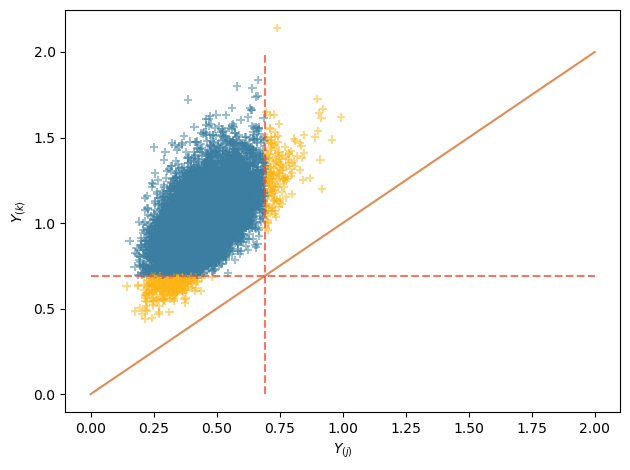

In [258]:
fig_quantile_CI_demo, ax = plt.subplots()

                                                   
ax.set_xlabel(r'$Y_{(j)}$')
ax.set_ylabel(r'$Y_{(k)}$')

col = np.where((CI[:,0]<=med_Y) & (CI[:,1]>=med_Y),'#3B7EA1','#FDB515') # the sample with (Xj<=med_Y<=Xk) will 
                # be plotted with the color '#3B7EA1', otherwise, it will be ploted with the color '#FDB515'

ax.scatter(CI[:,0], CI[:,1],color = col, alpha = 0.5, marker = '+') # each point indicates (Xj,Xk) from each sample

plt.plot((0, 2), (0, 2), color='#D9661F', alpha = 0.75) # 45-degree line
plt.plot((med_Y, med_Y), (0, 2), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=med_Y
plt.plot((0, 2), (med_Y, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the horizontal line with y=med_Y

# Save result
plt.tight_layout()
plt.savefig(graphics+'order_stat_CI_for_quantiles.png')

The plot above illustrates whether the interval $(X_j, X_k)$ from each sample contains the median of a Weibull distribution with parameters $(1/3, 1)$ denoted as med_Y. Blue points represent samples where this condition is satisfied, while orange points represent samples where it fails.

Because all points to the right of the vertical line at $x=$med_Y indicate $X_j>$med_Y, and similarly, all points below the horizontal line at $y=$med_Y indicate $X_k<$med_Y, both scenarios violate the condition that $(X_j, X_k)$ contains med_Y.

## Evaluating coverage

In [263]:
SE_hat         = ((N*(CI[:,1] - CI[:,0])**2)/(4*z_crit**2))**(1/2) # the estimate for the asymptotic variance of quantile

COV_Wald       = (med_Y_hat - z_crit*SE_hat/(N**(1/2))<=med_Y)*(med_Y_hat + z_crit*SE_hat/(N**(1/2))>=med_Y)
COV_order_stat = (CI[:,0]<=med_Y) & (CI[:,1]>=med_Y) 

print(np.mean(COV_order_stat)) # the fraction of samples where (Xj,Xk) contains med_Y
print(np.mean(COV_Wald))      # the fraction of sample where |sample quantile- population quantile|< z_crit*SE_hat/sqrt{N}

0.9486
0.9306


## Sampling distribution for estimated (i.e., sample!) median

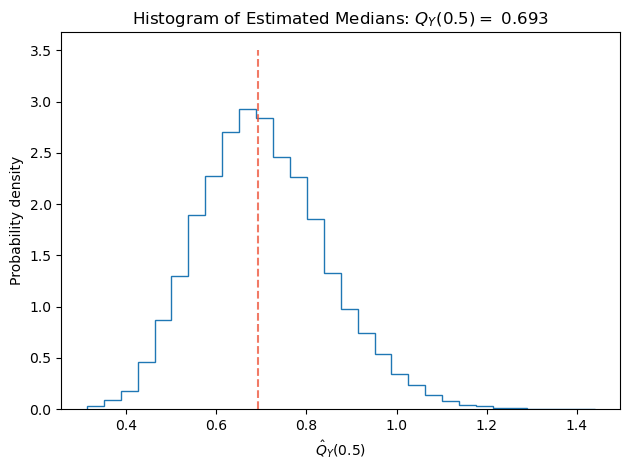

In [267]:
fig_med_Y_hat_hist, ax = plt.subplots()

n, bins, patches = ax.hist(med_Y_hat, bins = 30, density = True, histtype='step', align='mid') # the distribution of sample median


ax.plot((med_Y, med_Y), (0, 3.5), color='#ED4E33', alpha = 0.75, linestyle='dashed') # vertial line indicating the median
ax.set_xlabel(r'$\hat{Q}_{Y}\left(0.5\right)$')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of Estimated Medians: '
             r'$Q_Y\left(0.5\right)=$' + f' {med_Y:.3f}') 

# Tweak spacing to prevent clipping of ylabel
fig_med_Y_hat_hist.tight_layout()
plt.show()

## The distribution of Brazilian earnings   
We will now turn out attention to the PNAD data.

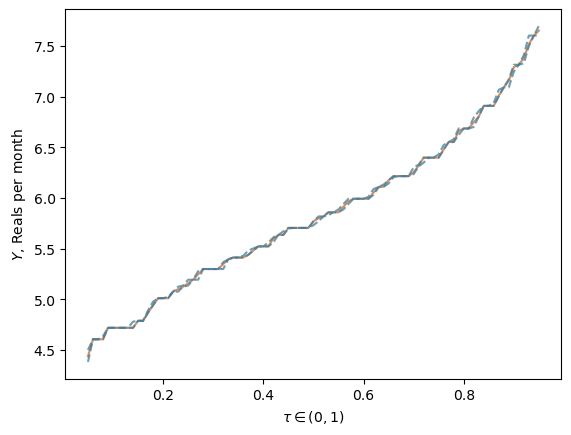

In [271]:
Y      = np.log(sample['MONTHLY_EARNINGS'])
N      = len(Y)  # the number of observations                                    
alpha  = 0.05    # set the confidence level
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # critical value from standard normal distribution
X      = np.sort(Y) # order statistics corresponding to the sample Y

results = {'tau' : [], 'Q_hat': [],'lower_CI' : [], 'upper_CI' : []}

# obtain the corresponding quantile estimator and 95% confidence intervals for each quantile tau
for tau in np.arange(0.05,0.96,0.01):
    l      = ((N*tau*(1-tau))**(1/2))*z_crit
    j      = int(np.floor(N*tau - l))
    k      = int(np.ceil(N*tau + l))
    results['tau'].append(tau)
    results['Q_hat'].append(np.quantile(X, tau))
    results['lower_CI'].append(X[j-1])
    results['upper_CI'].append(X[k-1])

    
results = pd.DataFrame.from_dict(results)    

# plot the results
fig_quantile_brazil_earns, ax = plt.subplots()
                                                   
ax.set_xlabel(r'$\tau \in (0,1)$')
ax.set_ylabel(r'$Y$, Reals per month')

plt.plot(results['tau'], results['Q_hat'], color='#D9661F', alpha = 0.75) # sample tau-th quantile 
plt.plot(results['tau'], results['lower_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed') # lower bound for the 1-alpha CI
plt.plot(results['tau'], results['upper_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed') # upper bound for the 1-alpha CI

In [273]:
# Inspect the contents of the results dataframe
results.head(15)    

,tau,Q_hat,lower_CI,upper_CI
0,0.05,4.436734,4.382027,4.499810
1,0.06,4.605170,4.605170,4.605170
2,0.07,4.605170,4.605170,4.605170
3,0.08,4.605170,4.605170,4.634729
4,0.09,4.718499,4.718499,4.718499
5,0.10,4.718499,4.718499,4.718499
6,0.11,4.718499,4.718499,4.718499
7,0.12,4.718499,4.718499,4.718499
8,0.13,4.718499,4.718499,4.718499
9,0.14,4.718499,4.718499,4.779123


Text(0.5, 0, 'Log Monthly Earnings')

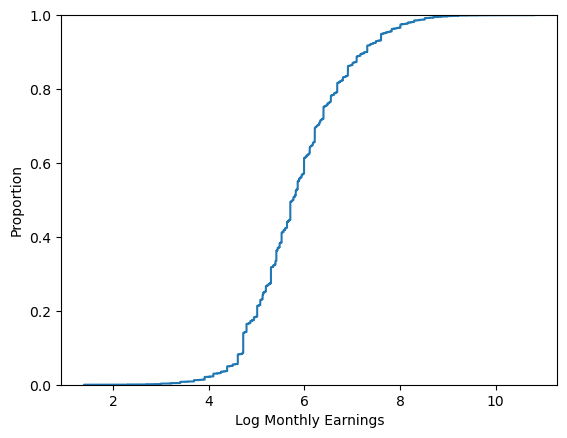

In [277]:
# Plot the empirical distribution of log(monthly earnings)
fig, ax = plt.subplots()
sns.ecdfplot(data=Y)
plt.xlabel('Log Monthly Earnings')

Coefficients for model [a]: 
 [ 0.14624197  0.08742562 -0.00087688]
Coefficients for model [b]: 
 [ 3.17425865e+00  3.37543591e+00  3.52052039e+00  3.65172797e+00
  3.84604065e+00  3.92693000e+00  4.02071069e+00  4.09357019e+00
  4.23939333e+00  4.31261087e+00  4.42782982e+00  4.72950148e+00
  4.96836744e+00  5.12186832e+00  5.21298598e+00  5.62293130e+00
  8.32977856e-02 -8.46141572e-04]


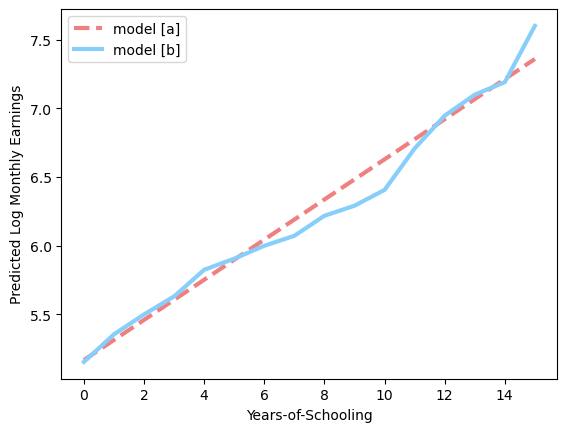

In [279]:
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)]


# (a) Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto a constant YRSSCH, AgeInDays, and AgeInDays squared
sample['AgeInDays_Sq'] = sample['AgeInDays']**2
regr_a = LinearRegression(fit_intercept=True).fit(sample[['YRSSCH','AgeInDays','AgeInDays_Sq']],Y)

# Print out the estimated regression coefficients
print("Coefficients for model [a]: \n", regr_a.coef_)

# (b) Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto each of the 16 dummy variables, AgeInDays, and AgeInDays squared.
dummy_sch = pd.get_dummies(sample['YRSSCH']) # create dummy variables for each of the 16 possible schooling levels
regr_b = LinearRegression(fit_intercept=False).fit(\
                                                pd.concat([dummy_sch,sample[['AgeInDays','AgeInDays_Sq']]],1),Y)
print("Coefficients for model [b]: \n", regr_b.coef_)

# (c) Plot the regression fits in [a] and [b] on the same figure holding AgeInDays fixed at 40, but varying YRSSCH
# obtain the regression fits in [a] and [b]
YRSSCH_level = np.sort(pd.unique(sample['YRSSCH']))
age = 40
X_pred_a = np.vstack((YRSSCH_level,age*np.ones_like(YRSSCH_level),age**2*np.ones_like(YRSSCH_level))).T
Y_pred_a = regr_a.predict(X_pred_a)

X_pred_b = pd.concat([pd.get_dummies(YRSSCH_level),pd.Series(age*np.ones_like(YRSSCH_level)),\
          pd.Series(age**2*np.ones_like(YRSSCH_level))],1)
Y_pred_b = regr_b.predict(X_pred_b)


# plot fitted regression model
plt.plot(YRSSCH_level,Y_pred_a, color="lightcoral", linewidth=3, linestyle='--')
plt.plot(YRSSCH_level,Y_pred_b, color="lightskyblue", linewidth=3)

plt.xlabel('Years-of-Schooling')
plt.ylabel('Predicted Log Monthly Earnings')

plt.legend(['model [a]','model [b]'])
plt.show()


In [283]:
obs_threshold = 30
results = {'YRSSCH' : [], 'Age_Range': [], 'Mid_Age': [], 'N': [], 'tau' : [], 'Q_hat': [],'lower_CI' : [], 'upper_CI' : [], 'SE_hat' : []}

for yrssch in YRSSCH_level:
    lage = 20
    while lage <= 60:
        subsample = sample.loc[(sample['YRSSCH']==yrssch) & (sample['AgeInDays']>=lage) \
                               & (sample['AgeInDays']<lage + 5)]
        N = len(subsample)

        if N >= obs_threshold:
            Y = np.log(subsample['MONTHLY_EARNINGS'])
            X = np.sort(Y)
            for tau in [0.1,0.25,0.5,0.75,0.9]:
                l      = ((N*tau*(1-tau))**(1/2))*z_crit
                j      = max(0,int(np.floor(N*tau - l))-1)
                k      = min(N-1,int(np.ceil(N*tau + l))-1)
                results['YRSSCH'].append(yrssch)
                results['Age_Range'].append('[{},{})'.format(lage,lage+5))
                results['Mid_Age'].append(lage+2.5)
                results['N'].append(N)
                results['tau'].append(tau)
                results['Q_hat'].append(np.quantile(X, tau))
                results['lower_CI'].append(X[j])
                results['upper_CI'].append(X[k])
                results['SE_hat'].append(((N*(X[k]-X[j])**2)/(4*z_crit**2))**(1/2))
        else:
            print("The group with year of schooling = {}, age range = [{},{}) doesn't have 30 obs".format(yrssch,lage,lage+5))
        lage = lage + 5 
results = pd.DataFrame.from_dict(results)

The group with year of schooling = 6, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 7, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 9, age range = [50,55) doesn't have 30 obs
The group with year of schooling = 9, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 9, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 10, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 10, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 12, age range = [20,25) doesn't have 30 obs
The group with year of schooling = 12, age range = [50,55) doesn't have 30 obs
The group with year of schooling = 12, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 12, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 13, age range = [20,25) doesn't have 30 obs
The group with year of schooling = 13, age range = [50,55

In [285]:
results[results['SE_hat']==0]

,YRSSCH,Age_Range,Mid_Age,N,tau,Q_hat,lower_CI,upper_CI,SE_hat
3,0,"[20,25)",22.5,758,0.75,5.298317,5.298317,5.298317,0.0
41,0,"[60,65)",62.5,697,0.25,4.605170,4.605170,4.605170,0.0
136,3,"[20,25)",22.5,632,0.25,4.718499,4.718499,4.718499,0.0
155,3,"[40,45)",42.5,590,0.10,4.718499,4.718499,4.718499,0.0
190,4,"[30,35)",32.5,1244,0.10,4.718499,4.718499,4.718499,0.0
195,4,"[35,40)",37.5,1439,0.10,4.718499,4.718499,4.718499,0.0
198,4,"[35,40)",37.5,1439,0.75,6.214608,6.214608,6.214608,0.0
225,5,"[20,25)",22.5,1088,0.10,4.718499,4.718499,4.718499,0.0
270,6,"[20,25)",22.5,733,0.10,4.718499,4.718499,4.718499,0.0
310,7,"[20,25)",22.5,721,0.10,4.718499,4.718499,4.718499,0.0


In [287]:
# Exclude all cells where the estimated standard error is zero.
results = results[results['SE_hat']!=0]
results['Mid_Age_Sq']= results['Mid_Age']**2


for tau in [0.1,0.25,0.5,0.75,0.9]:
    est_sample = results[results['tau']==tau]
    regr = LinearRegression(fit_intercept=True).fit(est_sample[['YRSSCH','Mid_Age','Mid_Age_Sq']],
                                                     est_sample['Q_hat'],sample_weight=1/est_sample['SE_hat'])
    
    print('The coefficient on schooling when tau equals to {} is {}'.format(tau,regr.coef_[0]))

The coefficient on schooling when tau equals to 0.1 is 0.13357327907446562
The coefficient on schooling when tau equals to 0.25 is 0.13883298229444269
The coefficient on schooling when tau equals to 0.5 is 0.149114545268576
The coefficient on schooling when tau equals to 0.75 is 0.1571514628189965
The coefficient on schooling when tau equals to 0.9 is 0.15434069711257592
